In [1]:
def dataBufferTo_dict(dataBuffer):
    dataBuffer2 = dataBuffer[0] # Remove from list
    keys = dataBuffer2[0]
    xData = dataBuffer2[2]
    yData = dataBuffer2[1]

    dataBuffer_dict = {}
    for (key, y) in zip(keys, yData):
        dataBuffer_dict[key] = y
    return keys, xData, dataBuffer_dict

captureDataList = []


def start_capture(duration, rate, signals):
    global captureDataList
    import typhoon.api.hil as hil

    anag_signals = []
    digi_signals = []

    for signal in signals:
        if signal in hil.get_analog_signals()[0]:
            anag_signals.append(signal)
        elif signal in hil.get_digital_signals()[0]:
            digi_signals.append(signal)
        else:
            raise Exception("'signal' em 'signals' nao eh valido!")

    decimation = 2
    n_channels = len(anag_signals)
    n_samples  = int(duration*rate)

    if len(digi_signals) > 0:
        enDigital = True
        chSettings = [anag_signals, digi_signals]
    else:
        enDigital = False
        chSettings = anag_signals

    cpSettings = [decimation, n_channels, n_samples, enDigital]
    trSettings = ['Forced']
    
    captureDataList = []

    hil.start_capture(cpSettings, trSettings, chSettings, captureDataList)


def get_capture_results(wait_capture=False):
    global captureDataList
    import typhoon.api.hil as hil
    
    if wait_capture == True:
        while hil.capture_in_progress():
            pass

    captureDataTuple = dataBufferTo_dict(captureDataList)
    chCaptured = captureDataTuple[2]

    chCaptured['time'] = pd.to_timedelta(captureDataTuple[1], unit='s')

    df = pd.DataFrame(chCaptured)
    df = df.set_index('time')
    
    return df

In [2]:
# def start_capture_and_wait(duration, rate, signals):
#     import typhoon.api.hil as hil

#     anag_signals = []
#     digi_signals = []

#     for signal in signals:
#         if signal in hil.get_analog_signals()[0]:
#             anag_signals.append(signal)
#         elif signal in hil.get_digital_signals()[0]:
#             digi_signals.append(signal)
#         else:
#             raise Exception("'signal' em 'signals' nao eh valido!")

#     decimation = 2
#     n_channels = len(anag_signals)
#     n_samples  = int(duration*rate)

#     if len(digi_signals) > 0:
#         enDigital = True
#         chSettings = [anag_signals, digi_signals]
#     else:
#         enDigital = False
#         chSettings = anag_signals

#     cpSettings = [decimation, n_channels, n_samples, enDigital]
#     trSettings = ['Forced']
    
#     captureDataList = []  

#     hil.start_capture(cpSettings, trSettings, chSettings, captureDataList)

#     while hil.capture_in_progress():
#         pass    

#     captureDataTuple = dataBufferTo_dict(captureDataList)
# #     print(captureDataTuple)

#     chCaptured = captureDataTuple[2]
# #     print(chCaptured)

#     chCaptured['time'] = pd.to_timedelta(captureDataTuple[1], unit='s')

#     df = pd.DataFrame(chCaptured)
#     df = df.set_index('time')
    
#     return df

In [2]:
import numpy as np
from numpy.fft import fft

def myFFT(t, y):
    import numpy as np
    from numpy.fft import fft, fftfreq
    Y = 2 * np.abs(fft(y)) / y.size
    Y = Y[:y.size//2]

    Y[0] = Y[0]/2
    
    f = fftfreq(t.size, t[1] - t[0])
    f = f[:y.size//2]
    
    return (f, Y)


def rmsValue(signal):    
    return np.sqrt(np.sum(np.power(signal, 2)) / signal.size)


def calculateTHD(signal, n_cycles, nh=50):
    
    signal = np.array(signal)

    zh = 2*np.abs(fft(signal))[:signal.size//2] / signal.size

    nh_array = np.arange(2, nh, 1)
    subHarIndex = nh_array * n_cycles
    
    fft_fund_values = zh[n_cycles]
    
    zh2 = zh[subHarIndex]
    
    THD = 100*np.sqrt(np.sum(np.power(zh2, 2))) / fft_fund_values
    
    return THD


def calculateTRD(signal, I_rated, n_cycles):
    signal = np.array(signal)
       
    zh = 2*np.abs(fft(signal))[:signal.size//2] / signal.size

    fft_fund_values = zh[n_cycles]
    
    fft_fund_values_rms = fft_fund_values/np.sqrt(2)

#     size_window = y2[0].size
    
    i_rms = rmsValue(signal)

    TRD = 100 * np.sqrt(np.power(i_rms, 2) - np.power(fft_fund_values_rms, 2)) / I_rated
    
    return TRD

# Pandas Module

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

## Reading a PSIM file

In [5]:
df1 = pd.read_csv('PD_12_04_2019.csv')

In [6]:
df1.head()

,Time,I(Ra),vo,Va,Vab,Vbc,Vca,Vbg,Vcg,Va_r,Vag
0,0.000001,183.905,400.0,0.000377,399.994,-5.684340e-13,-399.994,400.002,400.002,266.662,799.995
1,0.000002,183.905,400.0,0.000754,399.993,-5.115910e-13,-399.993,400.002,400.002,266.662,799.994
2,0.000003,183.904,400.0,0.001131,399.992,-4.547470e-13,-399.992,400.002,400.002,266.661,799.993
3,0.000004,183.904,400.0,0.001508,399.991,-5.684340e-13,-399.991,400.002,400.002,266.660,799.992
4,0.000005,183.903,400.0,0.001885,399.990,-4.547470e-13,-399.990,400.002,400.002,266.660,799.991


In [7]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html
df1 = df1.set_index('Time')

In [8]:
df1.head()

,I(Ra),vo,Va,Vab,Vbc,Vca,Vbg,Vcg,Va_r,Vag
Time,,,,,,,,,,
0.000001,183.905,400.0,0.000377,399.994,-5.684340e-13,-399.994,400.002,400.002,266.662,799.995
0.000002,183.905,400.0,0.000754,399.993,-5.115910e-13,-399.993,400.002,400.002,266.662,799.994
0.000003,183.904,400.0,0.001131,399.992,-4.547470e-13,-399.992,400.002,400.002,266.661,799.993
0.000004,183.904,400.0,0.001508,399.991,-5.684340e-13,-399.991,400.002,400.002,266.660,799.992
0.000005,183.903,400.0,0.001885,399.990,-4.547470e-13,-399.990,400.002,400.002,266.660,799.991


In [9]:
df1.tail()

,I(Ra),vo,Va,Vab,Vbc,Vca,Vbg,Vcg,Va_r,Vag
Time,,,,,,,,,,
0.099996,183.3380,398.924,-1.507960e-03,398.760,-3.979040e-13,-398.76,398.926,398.926,265.84,797.686
0.099997,183.3380,398.926,-1.130970e-03,398.760,-4.547470e-13,-398.76,398.927,398.927,265.84,797.687
0.099998,183.3380,398.927,-7.539820e-04,398.760,-5.684340e-13,-398.76,398.929,398.929,265.84,797.689
0.099999,183.3380,398.928,-3.769910e-04,398.760,-6.252780e-13,-398.76,398.930,398.930,265.84,797.690
0.100000,91.6691,398.929,2.990530e-11,398.761,-3.987610e+02,0.00,398.933,797.694,132.92,797.694


In [10]:
Vab = df1['Vab']
Vbc = df1['Vbc']

In [11]:
Vab.head()

Time
0.000001    399.994
0.000002    399.993
0.000003    399.992
0.000004    399.991
0.000005    399.990
Name: Vab, dtype: float64

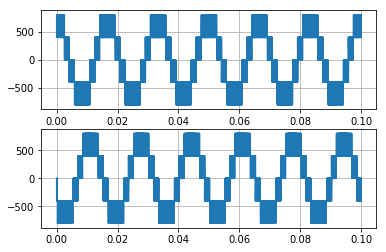

In [12]:
plt.subplot(211)
plt.plot(Vab.index, Vab)
plt.grid(True)
plt.subplot(212)
plt.plot(Vbc.index, Vbc)
plt.grid(True)
plt.show()

In [13]:
time = np.array(Vab.index)
Vab_a = np.array(Vab)

f, Y = myFFT(time, Vab_a)

(-1000, 200000)

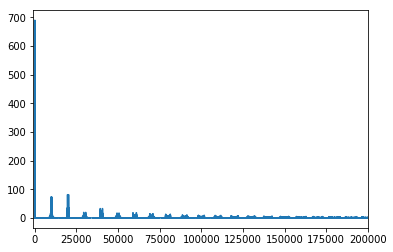

In [14]:
plt.plot(f, Y)
plt.xlim(-1000, 200000)

(0, 120)

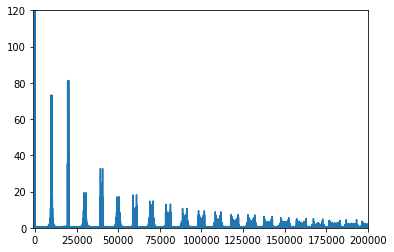

In [15]:
plt.plot(f, Y)
plt.xlim(-1000, 200000)
plt.ylim(0, 120)

(-10, 100)

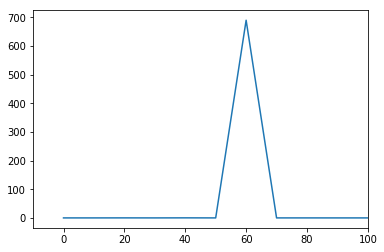

In [16]:
plt.plot(f, Y)
plt.xlim(-10, 100)

(-10, 100)

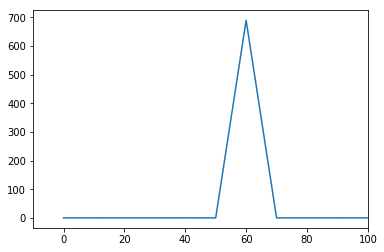

In [17]:
time = np.array(Vbc.index)
Vbc_a = np.array(Vbc)

f, Y = myFFT(time, Vbc_a)
plt.plot(f, Y)
plt.xlim(-10, 100)

## TRD and THD das medidas do DataFrame

### Cálculo da THD

$V = 2 \times V_{ab} + \times V_{bc} $

$Y = myFFT(V)$

### $THD \ [\%] = \frac{\sqrt{\sum ^{50}_{h = 2} Y_h}}{Y_1} \times 100$

Onde,

$Y_1$ = Amplitude da fundamental de $2 \times V_{ab} + V_{bc}$

$Y_h$ = Sub-harmônicas de $2 \times V_{ab} + V_{bc}$

In [18]:
signal = 2 * Vab_a + Vbc_a

print("THD(2 Vab + Vbc) = %.6f %%" % calculateTHD(signal, 6))
# ret = calculateTHD(signal, 6); ret

THD(2 Vab + Vbc) = 0.272736 %


### Cálculo da TRD

$I = I(Ra)$

$I_{rms} = rmsValue(I)$

$Y = myFFT(I)$

$I_{rated} = \frac{P_{nom}}{3 Vnom}$

### $TRD \ [\%] = \frac{\sqrt{I_{rms}^2 - Y_1^2}}{I_{rated}} \times 100$

Onde,

$I_{rms}$ = Valor RMS de $I(Ra)$

$Y_1$ = Amplitude da fundamental de $I$

$I_{rated}$ = A corrente (RMS) média de cada fase do inversor


In [19]:
Ira = df1['I(Ra)']

Pnom = 100e3 # VA
Vnom = 220 # V

Irated = Pnom/3/Vnom

print("Considerando Pnom = %d kVA e Vnom = %d V:" % (Pnom/1e3, Vnom))
print("\tTHD(Ira) = %.6f %%" % calculateTRD(Ira, Irated, 6))

Considerando Pnom = 100 kVA e Vnom = 220 V:
	THD(Ira) = 45.319158 %


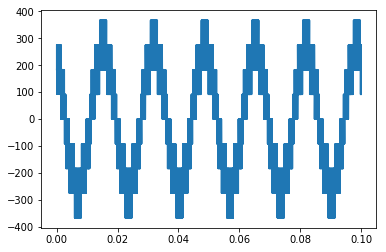

In [20]:
plt.plot(df1.index, Ira)
plt.show()

# Typhoon Module

## Estrutura do código para execução de testes em esquemáticos da Typhoon:

1. Importar a biblioteca  ``typhoon.api.hil``
2. Carregar o modelo **compilado** do esquemático
3. Setar as configurações de **estado inicial do circuito** de comutadores e conversores
4. Setar as configurações **iniciais de simulação** (tempo, canais, passo de captura)
5. Realizar a **captura**
    1. Pode se durante a captura realizar **mudanças no estado** dos comutadores
6. Obter os dados da captura e processá-los 

In [3]:
# 1. Importar a biblioteca  ``typhoon.api.hil``

import typhoon.api.hil as hil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1° Caso) Boost Closed Loop

In [22]:
# 2. Carregar o modelo **compilado** do esquemático

filename = "boost_closed_loop"

model_path = '{filename} Target files/{filename}.cpd'.format(filename=filename)

hil.load_model(file=model_path, vhil_device=True)

True

In [23]:
hil.get_contactors()

[['Load']]

In [ ]:
hil.set_contactor?

In [24]:
hil.get_pe_switching_blocks()

[['BOOST']]

In [ ]:
hil.set_pe_switching_block_control_mode?

In [25]:
hil.get_sources()

[['Vin']]

### Documentação

In [ ]:
# Documentação do Boost Converter

import webbrowser

webbrowser.open("file:///C:/Typhoon%20HIL%20Control%20Center/"+
                "typhoon/help/t-ug003/References/boost_converter.html")

In [26]:
hil.get_analog_signals()

[['BOOST.i1',
  'BOOST.i2',
  'BOOST.iboost',
  'BOOST.il',
  'BOOST.v1',
  'BOOST.v2',
  'C',
  'const_0V',
  'HIL0 analog input 1',
  'HIL0 analog input 10',
  'HIL0 analog input 11',
  'HIL0 analog input 12',
  'HIL0 analog input 13',
  'HIL0 analog input 14',
  'HIL0 analog input 15',
  'HIL0 analog input 16',
  'HIL0 analog input 2',
  'HIL0 analog input 3',
  'HIL0 analog input 4',
  'HIL0 analog input 5',
  'HIL0 analog input 6',
  'HIL0 analog input 7',
  'HIL0 analog input 8',
  'HIL0 analog input 9',
  'Iin',
  'Iout',
  'Iout_boost',
  'L',
  'Load.i',
  'Modulation Signal',
  'Vin',
  'VL',
  'Vout']]

In [27]:
hil.get_digital_signals()

[['BOOST.PWM_Modulator_BOT_1',
  'BOOST.PWM_Modulator_TOP_1',
  'enable',
  'HIL0 AO flag',
  'HIL0 digital input 1',
  'HIL0 digital input 10',
  'HIL0 digital input 11',
  'HIL0 digital input 12',
  'HIL0 digital input 13',
  'HIL0 digital input 14',
  'HIL0 digital input 15',
  'HIL0 digital input 16',
  'HIL0 digital input 17',
  'HIL0 digital input 18',
  'HIL0 digital input 19',
  'HIL0 digital input 2',
  'HIL0 digital input 20',
  'HIL0 digital input 21',
  'HIL0 digital input 22',
  'HIL0 digital input 23',
  'HIL0 digital input 24',
  'HIL0 digital input 25',
  'HIL0 digital input 26',
  'HIL0 digital input 27',
  'HIL0 digital input 28',
  'HIL0 digital input 29',
  'HIL0 digital input 3',
  'HIL0 digital input 30',
  'HIL0 digital input 31',
  'HIL0 digital input 32',
  'HIL0 digital input 4',
  'HIL0 digital input 5',
  'HIL0 digital input 6',
  'HIL0 digital input 7',
  'HIL0 digital input 8',
  'HIL0 digital input 9',
  'HIL0 DTV flag',
  'Load_fb']]

In [28]:
# 3. Setar as configurações de **estado inicial do circuito** de comutadores e conversores

hil.set_contactor('Load', swControl=True, swState=False)
hil.set_pe_switching_block_control_mode(
    blockName='BOOST', switchName='S1', swControl=False
)
hil.set_source_constant_value('Vin', 35)

True

In [29]:
# 4. Setar as configurações **iniciais de simulação** (tempo, canais, passo de captura)
# 5. Realizar a **captura**

channels = ['Iout', 'BOOST.PWM_Modulator_BOT_1', 'Vout', 'BOOST.PWM_Modulator_TOP_1', 'Load_fb']
duration = 5
cap_step = 2e-6
rate = int(1//cap_step)

hil.start_simulation()

start_capture(duration, rate, channels)

print('Waiting a sec')
hil.wait_sec(1)
print('Sec waited')

hil.set_contactor('Load', True, True)

df = get_capture_results(wait_capture=True)

hil.stop_simulation()

Waiting a sec
Sec waited


True

In [30]:
df1 = df.copy()
df1.index /= np.timedelta64(1, 's')

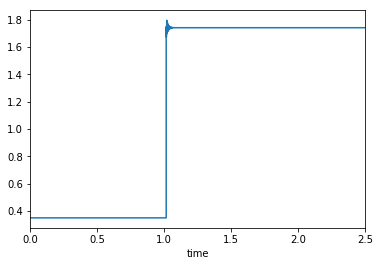

In [31]:
df1['Iout'].plot()

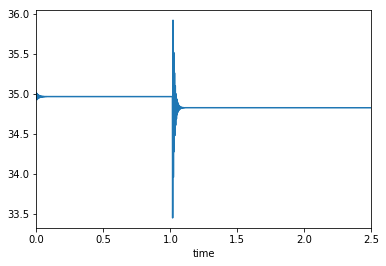

In [32]:
df1['Vout'].plot()

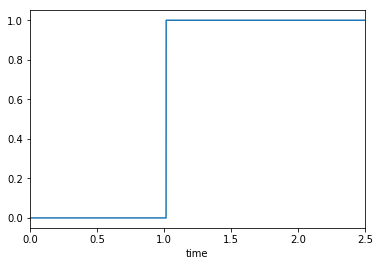

In [33]:
df1['Load_fb'].plot()

In [34]:
hil.set_contactor('Load', swControl=True, swState=False)
hil.set_contactor('Load', True, True, executeAt=1)
hil.set_contactor('Load', True, False, executeAt=2)

True

In [35]:
channels = ['Iout', 'BOOST.PWM_Modulator_BOT_1', 'Vout', 'BOOST.PWM_Modulator_TOP_1', 'Load_fb']
duration = 5
cap_step = 2e-6
rate = int(1//cap_step)

hil.start_simulation()

start_capture(duration, rate, channels)

hil.set_contactor('Load', True, False, executeAt=2)

df = get_capture_results(wait_capture=True)

hil.stop_simulation()

True

In [36]:
df1 = df.copy()
df1.index /= np.timedelta64(1, 's')

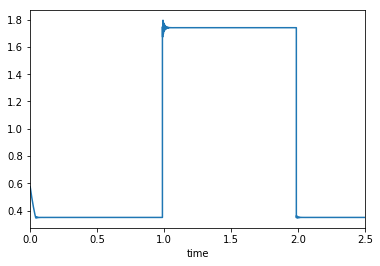

In [37]:
df1['Iout'].plot()

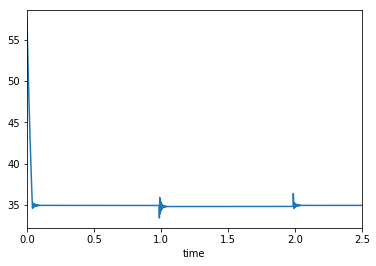

In [38]:
df1['Vout'].plot()

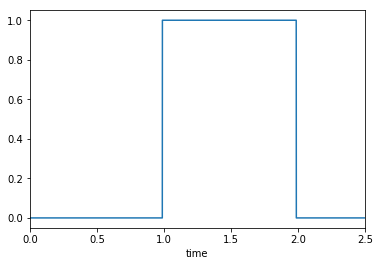

In [39]:
df1['Load_fb'].plot()

## 2° Caso) Two-Level Inverter

In [4]:
filename = "two_level_carrier_based"

model_path = '{filename} Target files/{filename}.cpd'.format(filename=filename)

hil.load_model(file=model_path, vhil_device=True)

True

In [5]:
hil.get_analog_signals() + hil.get_digital_signals() + \
hil.get_pe_switching_blocks() + hil.get_contactors() + \
hil.get_sources() + hil.get_scada_inputs()

[['Ca',
  'Cb',
  'Cc',
  'const_0V',
  'Core Coupling 1.cpl1.I_msr',
  'Core Coupling 1.cpl1.V_msr',
  'Core Coupling 1.cpl2.I_msr',
  'Core Coupling 1.cpl2.V_msr',
  'HIL0 analog input 1',
  'HIL0 analog input 10',
  'HIL0 analog input 11',
  'HIL0 analog input 12',
  'HIL0 analog input 13',
  'HIL0 analog input 14',
  'HIL0 analog input 15',
  'HIL0 analog input 16',
  'HIL0 analog input 2',
  'HIL0 analog input 3',
  'HIL0 analog input 4',
  'HIL0 analog input 5',
  'HIL0 analog input 6',
  'HIL0 analog input 7',
  'HIL0 analog input 8',
  'HIL0 analog input 9',
  'Ia1',
  'Ia2',
  'Ib1',
  'Ib2',
  'Ic1',
  'Ic2',
  'La.flux',
  'La.Lint',
  'La.V',
  'Lb.flux',
  'Lb.Lint',
  'Lb.V',
  'Lb1',
  'Lc.flux',
  'Lc.Lint',
  'Lc.V',
  'Lc1',
  'max',
  'min',
  'Ra.I',
  'Rb.I',
  'Rb.L',
  'Rc.I',
  'Rc.L',
  'Three Phase Inverter1.IGBT Leg1.il',
  'Three Phase Inverter1.IGBT Leg1.v1',
  'Three Phase Inverter1.IGBT Leg1.v2',
  'Three Phase Inverter1.IGBT Leg2.il',
  'Three Phase Inve

### Documentação

In [ ]:
# Documentação do Two Level Rectifier

import webbrowser

webbrowser.open("file:///C:/Typhoon%20HIL%20Control%20Center/" +
                "typhoon/help/t-ug003/References/"+
                "three-phase_two-level_inverter_rectifier.html")

In [6]:
for switch_name in ['Sa_top', 'Sa_bot', 'Sb_top', 'Sb_bot', 'Sc_top', 'Sb_bot']:
    hil.set_pe_switching_block_control_mode(
        blockName='Three Phase Inverter1', switchName=switch_name, swControl=False
    )

hil.set_source_constant_value('Vs1', 800)

hil.set_scada_input_value('inductance', 50e-6)
hil.set_scada_input_value('resistance', 100)
hil.set_scada_input_value('modulation index', 1.0)

True

In [7]:
sa_bot = 'Three Phase Inverter1.IGBT Leg1.PWM_Modulator_BOT_1'
sb_bot = 'Three Phase Inverter1.IGBT Leg2.PWM_Modulator_BOT_1'
sc_bot = 'Three Phase Inverter1.IGBT Leg3.PWM_Modulator_BOT_1'

channels = ['Vab', 'Vbc', 'Ia1', 'Ib1', 'Ic1', #'Three Phase Inverter1.IGBT Leg1.PWM_Modulator_BOT_1', 
            sa_bot, sb_bot, sc_bot]

duration = 5
rate = 200e3 #Hz

hil.start_simulation()

start_capture(duration, rate, channels)

df = get_capture_results(wait_capture=True)

hil.stop_simulation()

True

In [ ]:
df1 = df.copy()
df1.index /= np.timedelta64(1, 's')

In [ ]:
df1['Vab'].plot()

In [ ]:
# Slicing a dataframe
df1 = df1[:5/60]

In [ ]:
df1.tail()

In [ ]:
df1['Vab'].plot()

In [ ]:
plt.plot(df1.index, 2 * df1['Vab'] + df1['Vbc'])

In [ ]:
print('THD(2 * Vab + Vbc) = %.6f %%' % calculateTHD(2 * df1['Vab'] + df1['Vbc'], 5))

In [ ]:
Pnom = 100e3 # VA
Vnom = 220 # V

I_rated = Pnom/3/220

print("Considerando Pnom = %d kVA e Vnom = %d V:\n" % (Pnom/1e3, Vnom))

TRD_1 = calculateTRD(df1['Ia1'], I_rated, 5)
print('TRD(Ia1) = %.6f %%' % calculateTRD(df1['Ia1'], I_rated, 5))

TRD_2 = calculateTRD(df1['Ib1'], I_rated, 5)
print('TRD(Ib2) = %.6f %%' % calculateTRD(df1['Ib1'], I_rated, 5))

TRD_3 = calculateTRD(df1['Ic1'], I_rated, 5)
print('TRD(Ic1) = %.6f %%' % calculateTRD(df1['Ic1'], I_rated, 5))

print('\nTRD Médio (Ia1, Ib1, Ic1) = %.6f %%' % np.mean([TRD_1, TRD_2, TRD_3]))

In [ ]:
plt.plot(df1.index, df1['Ia1'])
plt.plot(df1.index, df1['Ib1'])
plt.plot(df1.index, df1['Ic1'])
plt.show()

In [ ]:
df1 = df.copy()
df1.index /= np.timedelta64(1, 's')

df1 = df1[5/60: 10/60]

In [ ]:
plt.plot(df1.index, df1['Ia1'])
plt.plot(df1.index, df1['Ib1'])
plt.plot(df1.index, df1['Ic1'])
plt.show()

In [ ]:
print('THD(2 * Vab + Vbc) = %.6f %%' % calculateTHD(2 * df1['Vab'] + df1['Vbc'], 5))

In [ ]:
Pnom = 100e3 # VA
Vnom = 220 # V

I_rated = Pnom/3/220

print("Considerando Pnom = %d kVA e Vnom = %d V:\n" % (Pnom/1e3, Vnom))

TRD_1 = calculateTRD(df1['Ia1'], I_rated, 5)
print('TRD(Ia1) = %.6f %%' % calculateTRD(df1['Ia1'], I_rated, 5))

TRD_2 = calculateTRD(df1['Ib1'], I_rated, 5)
print('TRD(Ib2) = %.6f %%' % calculateTRD(df1['Ib1'], I_rated, 5))

TRD_3 = calculateTRD(df1['Ic1'], I_rated, 5)
print('TRD(Ic1) = %.6f %%' % calculateTRD(df1['Ic1'], I_rated, 5))

print('\nTRD Médio (Ia1, Ib1, Ic1) = %.6f %%' % np.mean([TRD_1, TRD_2, TRD_3]))

In [ ]:
plt.plot(df1.index, df1[sa_bot], label='sa_bot')
plt.plot(df1.index, df1[sb_bot] - 1.25, label='sb_bot')
plt.plot(df1.index, df1[sc_bot] - 2.5, label='sc_bot')

min = df1.index[0]
plt.xlim(min, min+.1/60)
plt.legend()

#### Exercício: Desenvolver um contador de comutações por segundo

In [ ]:
comA = np.array(df1[sa_bot])[:200]
plt.plot(comA)

In [ ]:
aux1 = comA[:-1]
aux2 = comA[1:]

diff = aux2 - aux1
plt.plot(diff)

In [ ]:
diff_abs = np.abs(diff)
plt.plot(diff_abs)

In [ ]:
n_com = np.sum(diff_abs == True); n_com

In [ ]:
def commutationCount(signal, n_cycles, fnom=60):
    aux1 = signal[:-1]
    aux2 = signal[1:]

    diff = aux2 - aux1
    
    print()
    
    diff_abs = np.abs(diff)

    n_com = np.sum(diff_abs == True)
    
    return n_com * fnom/n_cycles

comA = np.array(df1[sa_bot])
commutationCount(comA, 5)

**Espero terminar Aqui!**

## 3° Caso) NPC

In [8]:
filename = "NPC_SVM"

model_path = '{filename} Target files/{filename}.cpd'.format(filename=filename)

hil.load_model(file=model_path, vhil_device=True)

True

In [6]:
hil.get_sources() + hil.get_pe_switching_blocks() + \
hil.get_scada_inputs() + hil.get_contactors() + \
hil.get_analog_signals() + hil.get_digital_signals()

[['Vs1'],
 ['LegA', 'LegB', 'LegC'],
 ['inductance', 'modulation index', 'resistance'],
 [],
 ['C1',
  'C2',
  'Ca',
  'Cb',
  'Cc',
  'const_0V',
  'Core Coupling 1.cpl1.I_msr',
  'Core Coupling 1.cpl1.V_msr',
  'Core Coupling 1.cpl2.I_msr',
  'Core Coupling 1.cpl2.V_msr',
  'd1',
  'd2',
  'd3',
  'error',
  'HIL0 analog input 1',
  'HIL0 analog input 10',
  'HIL0 analog input 11',
  'HIL0 analog input 12',
  'HIL0 analog input 13',
  'HIL0 analog input 14',
  'HIL0 analog input 15',
  'HIL0 analog input 16',
  'HIL0 analog input 2',
  'HIL0 analog input 3',
  'HIL0 analog input 4',
  'HIL0 analog input 5',
  'HIL0 analog input 6',
  'HIL0 analog input 7',
  'HIL0 analog input 8',
  'HIL0 analog input 9',
  'hysteresis',
  'I_mid_DC',
  'Ia1',
  'Ia2',
  'Ib1',
  'Ib2',
  'Ic1',
  'Ic2',
  'La.flux',
  'La.Lint',
  'La.V',
  'Lb.flux',
  'Lb.Lint',
  'Lb.V',
  'Lb1',
  'Lc.flux',
  'Lc.Lint',
  'Lc.V',
  'Lc1',
  'LegA.il',
  'LegA.v1',
  'LegA.v2',
  'LegA.vZ',
  'LegB.il',
  'LegB.

### Documentação

In [7]:
# Documentação do NPC Leg

import webbrowser

webbrowser.open("file:///C:/Typhoon%20HIL%20Control%20Center/" +
                "typhoon/help/t-ug003/References/npc_leg.html")

True

In [8]:
legs = ['LegA', 'LegB', 'LegC']
switchs = ['S1', 'S2', 'S3', 'S4']

for leg in legs:
    for switch in switchs:
        hil.set_pe_switching_block_control_mode(
            blockName=leg, switchName=switch, swControl=False
        )

hil.set_source_constant_value('Vs1', 800)

hil.set_scada_input_value('inductance', 50e-6)
hil.set_scada_input_value('resistance', 100)
hil.set_scada_input_value('modulation index', 1.0)

True

In [9]:
sa_bot_1 = 'LegA.PWM_Modulator_BOT_1'
sa_bot_2 = 'LegA.PWM_Modulator_BOT_2'
sb_bot_1 = 'LegB.PWM_Modulator_BOT_1'
sb_bot_2 = 'LegB.PWM_Modulator_BOT_2'
sc_bot_1 = 'LegC.PWM_Modulator_BOT_1'
sc_bot_2 = 'LegC.PWM_Modulator_BOT_2'

channels = ['Vab', 'Vbc', 'Ia1', 'Ib1', 'Ic1',
            sa_bot_1, sa_bot_2, sb_bot_1, sb_bot_2, sc_bot_1, sc_bot_2]

duration = 5
rate = 200e3 #Hz

hil.start_simulation()

start_capture(duration, rate, channels)

df = get_capture_results(wait_capture=True)

hil.stop_simulation()

True

In [23]:
df1 = df.copy()
df1.index /= np.timedelta64(1, 's')

df1 = df1[:12/60]

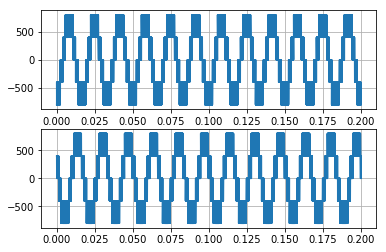

In [24]:
plt.subplot(211)
plt.plot(df1.index, df1.Vab)
plt.grid(True)
plt.subplot(212)
plt.plot(df1.index, df1.Vbc)
plt.grid(True)
plt.show()

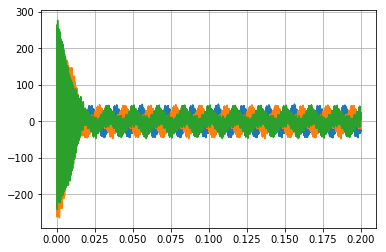

In [25]:
plt.plot(df1.index, df1.Ia1)
plt.plot(df1.index, df1.Ib1)
plt.plot(df1.index, df1.Ic1)
plt.grid(True)
plt.show()

In [26]:
TRD_1 = calculateTRD(df1['Ia1'], I_rated, 5)
TRD_2 = calculateTRD(df1['Ib1'], I_rated, 5)
TRD_3 = calculateTRD(df1['Ic1'], I_rated, 5)

print('TRD Médio (Ia1, Ib1, Ic1) = %.6f %%' % np.mean([TRD_1, TRD_2, TRD_3]))

TRD Médio (Ia1, Ib1, Ic1) = 18.059620 %


In [27]:
df1 = df.copy()
df1.index /= np.timedelta64(1, 's')

df1 = df1[4/60:16/60]

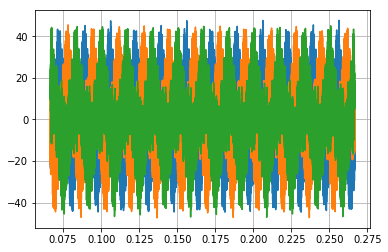

In [28]:
plt.plot(df1.index, df1.Ia1)
plt.plot(df1.index, df1.Ib1)
plt.plot(df1.index, df1.Ic1)
plt.grid(True)
plt.show()

In [31]:
Pnom = 100e3 # VA
Vnom = 220 # V

I_rated = Pnom/3/220

print("Considerando Pnom = %d kVA e Vnom = %d V:\n" % (Pnom/1e3, Vnom))

TRD_1 = calculateTRD(df1['Ia1'], I_rated, 5)
print('TRD(Ia1) = %.6f %%' % calculateTRD(df1['Ia1'], I_rated, 12))

TRD_2 = calculateTRD(df1['Ib1'], I_rated, 5)
print('TRD(Ib2) = %.6f %%' % calculateTRD(df1['Ib1'], I_rated, 12))

TRD_3 = calculateTRD(df1['Ic1'], I_rated, 5)
print('TRD(Ic1) = %.6f %%' % calculateTRD(df1['Ic1'], I_rated, 12))

print('\nTRD Médio (Ia1, Ib1, Ic1) = %.6f %%' % np.mean([TRD_1, TRD_2, TRD_3]))

Considerando Pnom = 100 kVA e Vnom = 220 V:

TRD(Ia1) = 6.369520 %
TRD(Ib2) = 6.379531 %
TRD(Ic1) = 6.373710 %

TRD Médio (Ia1, Ib1, Ic1) = 9.675935 %


In [29]:
print('THD(2 * Vab + Vbc) = %.6f %%' % calculateTHD(2 * df1['Vab'] + df1['Vbc'], 12))

THD(2 * Vab + Vbc) = 0.786651 %


## 4° Caso)  Droop

In [ ]:
# MOSTRAR NO SPYDER